In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import scipy  
from scipy.linalg import null_space


from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import Statevector
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple, ImaginaryMcLachlanPrinciple
from qiskit_algorithms import TimeEvolutionProblem, VarQRTE, VarQITE
from qiskit_algorithms.gradients import ReverseEstimatorGradient, ReverseQGT, DerivativeType
import matplotlib.pyplot as plt


In [2]:
##Define Pauli Matrices

Sigma_x = np.matrix([[0, 1], [1, 0]])
Sigma_y = np.matrix([[0, -1j], [1j, 0]])
Sigma_z = np.matrix([[1, 0], [0, -1]])
Sigma_plus = (Sigma_x +1j*Sigma_y)/2
Sigma_minus = Sigma_plus.getH()
numberop = Sigma_minus@Sigma_plus

In [3]:

#Functions from article:
def Liouvillian(H, Ls, hbar = 1):
    d = len(H) # dimension of the system
    superH = -1j/hbar * ( np.kron(np.eye(d),H)-np.kron(H.T,np.eye(d)) ) # Hamiltonian part
    superL = sum([np.kron(L.conjugate(),L) 
                  - 1/2 * ( np.kron(np.eye(d),L.conjugate().T.dot(L)) +
                            np.kron(L.T.dot(L.conjugate()),np.eye(d)) 
                          ) for L in Ls])
    return superH + superL

def verify_density_matrix(rho):
    # Check Hermitian
    hermitian = np.allclose(rho, rho.conj().T)
    print(f"Is Hermitian: {hermitian}")
    
    # Check trace is 1
    trace = np.trace(rho)
    print(f"Trace: {trace} (should be 1)")
    
    # Check positive semidefinite?
    eigenvalues = np.linalg.eigvalsh(rho)
    print(f"Eigenvalues: {eigenvalues}")
    print(f"All eigenvalues ≥ 0: {np.all(eigenvalues >= 0)}")
    
    # Check purity 
    purity = np.trace(rho @ rho)
    print(f"Purity (Tr(ρ²)): {purity} (should be 1 for pure state)")


In [4]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

def hamiltonian_generation(eps, gamma, mu, T):
    """
    Generates the Hamiltonian for the system of a single qubit coupled to a reservoir.

    Inputs:
        eps: (float) Coupling strength of the qubit to the reservoir.
        gamma: (float) Coupling strength of the qubit to the environment.
        mu: (float) Chemical potential of the reservoir.
        T: (float) Temperature of the reservoir.
    Returns:
        hamiltonian_re: SparsePauliOp representing the real part of the Hamiltonian of the system.
        hamiltonian_im: SparsePauliOp representing the imaginary part of the Hamiltonian of the system.
    """
    
    F = 1 / (1 + np.exp((eps - mu) / T))
    hamiltonian_re = SparsePauliOp(["IZ", "ZI", "XY", "YX"], coeffs=[-eps / 2, eps / 2, -(gamma * (1 - 2*F)) / 4, -(gamma * (1 - 2*F)) / 4])
    hamiltonian_im = -1 * SparsePauliOp(["XX", "YY", "II", "IZ", "ZI"], coeffs=[gamma / 4, -gamma / 4, -gamma / 2, (gamma * (1 - 2*F)) / 4, (gamma * (1 - 2*F)) / 4])
    
    return hamiltonian_re, hamiltonian_im

def hamiltonian_generation_simple():
    """
    Generates a simple Hamiltonian for a single qubit system.

    Returns:
        hamiltonian_re: SparsePauliOp representing the Hamiltonian.
    """
    return SparsePauliOp(["IX", "XI"], coeffs=[1, -1])  # Example coefficients

def statevector_to_densitymatrix(v):
    """
    Converts a Statevector to a density matrix.

    Inputs:
        v: (numpy.ndarray) The state vector to be converted.
    
    Returns:
        (numpy.ndarray) The corresponding density matrix.
    """
    m = int(np.sqrt(len(v)))
    return np.reshape(v, (m, m), order='F')

In [5]:
##Parameters for the simulation

eps = 1
gamma = 1
mu = 0 # chemical potential
T = 100 #temperature
F = 1 / (1 + np.exp((eps - mu) / T))

# Time evolution parameters
time = 10.0
nt = 100
dt = time / nt

ham_real, ham_imag = hamiltonian_generation(eps, gamma, mu, T)


ansatz = EfficientSU2(ham_real.num_qubits, reps=1)
init_param_values = {}
for i in range(len(ansatz.parameters)):
    init_param_values[ansatz.parameters[i]] = (
        np.pi / 8
    )  # initialize the parameters which also decide the initial state
init_state = Statevector(ansatz.assign_parameters(init_param_values))


# Get the statevector's data as a NumPy array
psi_vector = init_state.data
rho_matrix = psi_vector.reshape(2 ,2, order='F')


initial_state = np.matrix(rho_matrix)

print("Initial State for exact diag:", initial_state)
print("Initial VQE:" , init_state)


Initial State for exact diag: [[0.61992668-0.64308201j 0.31615777-0.07099076j]
 [0.15997913-0.05642574j 0.24563445+0.08959659j]]
Initial VQE: Statevector([0.61992668-0.64308201j, 0.15997913-0.05642574j,
             0.31615777-0.07099076j, 0.24563445+0.08959659j],
            dims=(2, 2))


In [6]:
#VQE Method


# Generate Hamiltonian
ham_real, ham_imag = hamiltonian_generation(eps, gamma, mu, T)

# Define the variational principles for time evolution
real_var_principle = RealMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient(derivative_type=DerivativeType.IMAG))
imag_var_principle = ImaginaryMcLachlanPrinciple(qgt=ReverseQGT(), gradient=ReverseEstimatorGradient())


# Initialize lists to store results
#second is the is expectation value of the number operator
trace_list = [1.0]
num_op_list = [np.trace(statevector_to_densitymatrix(init_state.data) @ np.array([[0, 0], [0, 1]])) / np.trace(statevector_to_densitymatrix(init_state.data))]
print("Initial expectation value of number operator:", num_op_list[0])


# Perform time evolution
for t in range(1, nt):
    # Real evolution
    evolution_problem = TimeEvolutionProblem(ham_real, dt / 2)
    var_qrte = VarQRTE(ansatz, init_param_values, real_var_principle, num_timesteps=1)
    evolution_result_re = var_qrte.evolve(evolution_problem)
    init_param_values = evolution_result_re.parameter_values[-1]
    
    # Imaginary evolution
    evolution_problem = TimeEvolutionProblem(ham_imag, dt / 2)
    var_qite = VarQITE(ansatz, init_param_values, imag_var_principle, num_timesteps=1)
    evolution_result_im = var_qite.evolve(evolution_problem)
    init_param_values = evolution_result_im.parameter_values[-1]
    
    # Calculate the trace and expectation value of the number operator
    trace = np.trace(statevector_to_densitymatrix(Statevector(ansatz.assign_parameters(init_param_values)).data))
    trace_list.append(1.0) # Normalized so the trace is always 1
    num_op_list.append(np.trace(statevector_to_densitymatrix(Statevector(ansatz.assign_parameters(init_param_values)).data) @ np.array([[0, 0], [0, 1]])) / trace)

# # Plotting the results
# plt.plot(np.linspace(0, time, nt), trace_list, label='Trace of Density Matrix')
# plt.plot(np.linspace(0, time, nt), num_op_list, label='Expectation Value of Number Operator')
# plt.plot(np.linspace(0, time, nt), [1 / (1 + np.exp((eps - mu) / T))] * nt, label='Steady State Expectation Value', linestyle='--')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.title('Time Evolution of Density Matrix and Number Operator')
# plt.legend()
# plt.grid()
# plt.show()

Initial expectation value of number operator: (0.1544431211984246+0.2022718001862916j)


In [7]:
# Define Hamiltonian
H = eps*Sigma_minus@Sigma_plus

#Define lindblad operators
L_plus = np.sqrt(gamma*(1-F)) * Sigma_plus
L_minus = np.sqrt(gamma*F) * Sigma_minus

L_K = [L_minus, L_plus] 



Superoperator = Liouvillian(H, L_K)
null = null_space(Superoperator)
NULL = null[:, 0]
rho_ss = NULL.reshape(2, 2)
rho_ss = rho_ss / np.trace(rho_ss)

referenceN = np.trace(numberop @ rho_ss)
print(f"Reference number operator expectation value: {referenceN}")

# verify_density_matrix(rho_ss)
verify_density_matrix(initial_state)

# Create time evolution operator
U = scipy.linalg.expm(Superoperator * dt)
rho_t = initial_state.reshape(4,1)  # Vectorized  state

expectation_value_history = [np.trace(numberop @ initial_state) / np.trace(initial_state)]
print("Initial expectation value of number operator:", expectation_value_history[0])
time_points = [0]

# Time evolution loop
for step in range(nt):
    rho_t = U @ rho_t
    rho_matrix = rho_t.reshape(2 ,2)
    rho_matrix = rho_matrix / np.trace(rho_matrix)
    expectation_value_history.append(np.trace(numberop @ rho_matrix))
    time_points.append((step + 1) * dt)

# # Plotting
# plt.plot(np.linspace(0, time, nt), trace_list, label='Trace of Density Matrix')
# plt.plot(time_points, expectation_value_history, label='Expectation Value')
# plt.axhline(y=referenceN, color='r', linestyle='--', label='Reference')
# plt.xlabel('Time')
# plt.ylabel('Expectation Value of Number Operator')
# plt.title('Expectation Value Evolution')
# plt.legend()
# plt.grid(True)
# plt.show()



Reference number operator expectation value: (0.49750002083312495+0j)
Is Hermitian: False
Trace: (0.8655611338876885-0.5534854135545023j) (should be 1)
Eigenvalues: [0.18019226 0.68536887]
All eigenvalues ≥ 0: True
Purity (Tr(ρ²)): (0.11620923226024857-0.8117043148863365j) (should be 1 for pure state)
Initial expectation value of number operator: (0.1544431211984246+0.2022718001862916j)


C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tessa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


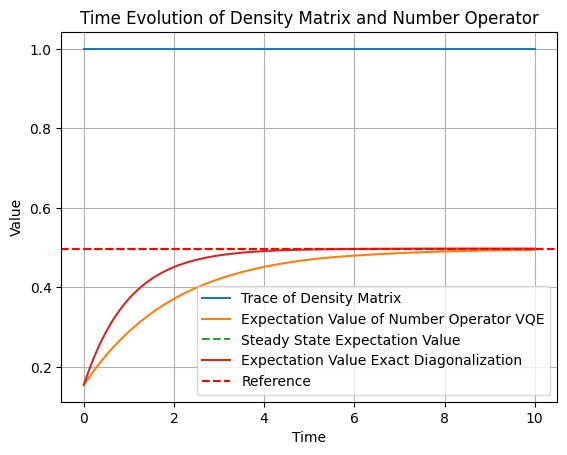

In [8]:
plt.plot(np.linspace(0, time, nt), trace_list, label='Trace of Density Matrix')
plt.plot(np.linspace(0, time, nt), num_op_list, label='Expectation Value of Number Operator VQE')
plt.plot(np.linspace(0, time, nt), [1 / (1 + np.exp((eps - mu) / T))] * nt, label='Steady State Expectation Value', linestyle='--')
plt.plot(time_points, expectation_value_history, label='Expectation Value Exact Diagonalization')
plt.axhline(y=referenceN, color='r', linestyle='--', label='Reference')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Evolution of Density Matrix and Number Operator')
plt.legend()
plt.grid()
plt.show()